# Overview of First Pass
For the first pass I have created a model with feature tools and a Elo model (eventually we can combine with features created with FT). This notebook should run completely and my thoughts/comments are in the notebook and at the end. Other notebooks are in the first_pass notebooks folder.
### Results
- A basic model using seed, region, and game datetime gives an accuracy of .65 and log loss of .63 but appears to be overfitting.  
- Elo gives accuracy of .659 and log loss of .61 using different features (score1,score2,game_location). 
  - I think there is room to tune this up accuracy near 70% range if not slightly higher. 
- I didn't get to use as much data as I hoped in this first pass. I think I have the general approach done now but see my questions below regarding data format  
  
### Issues
I ran into some issues with featuretools and was wondering if there was a better way than what I was trying  
  
- Can I use compound column indexes/keys in feature tools?
- feature vector has team_1_id and team_2_id. I wanted to add two relationships from a seeds and season table that has teamID, region, and seed. 
  - When I tried to add two relationships I got a diamond graph error. 
  - I opted to create separate feature vectors for each team and then merge them after running DFS. This misses out on DFS interactions between teams like a 1 seed vs a 5 seed.
  - There were some issues maintaining feature_defs so I switched to columns
- How to handle creating aggregate stats on records of regular season games? I wanted to get 1 summary row for each team with features generated with primitives and use that to make predictions on march madness games.  
  - I thought I could do something with cutoff times but couldn't quite get it to work and didn't want to spend too much time figuring it out without checking with you on my approach. Is the cutoff label something I could try to use? https://github.com/Featuretools/predict-next-purchase/blob/master/utils.py . Am I on the right path?
  - Would using two entity sets be a good alternative? I think it is a many to many relationship  - Or maybe it would be best to combine the regular season data with potential tourney games so I don't need another relationship and can just use game_datetime

In [1]:
import sys,os
folder_name="march_madness"
BASE_DIR=os.path.abspath(".").split(folder_name)[0]+folder_name
DATA_ROOT=os.path.join(BASE_DIR,"data")
#todo setup shared utilities folder
sys.path.insert(0, DATA_ROOT)

In [2]:
import pandas as pd
pd.options.display.max_rows=5#So we don't have to always write head
pd.options.display.max_columns=999
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import featuretools as ft

# Load Data  
For the first pass I used:  
- Regular Season Detailed Results  
  - boxscore stats like field goal made and scores -- goes back to 2003 -- just results goes to 1985
- Tourney Seeds
- Tourney Detailed Results
   - similar to regular season
- Team Conferences
- Teams
- Season info 
  - Used to get day of week for games and region names

In [3]:
regular_season_results_df=pd.read_csv(DATA_ROOT+"/DataFiles/RegularSeasonDetailedResults.csv")
regular_season_results_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82039,2018,132,1246,77,1397,72,N,0,25,50,7,16,20,24,11,21,9,10,6,6,19,23,62,10,27,16,20,18,16,14,10,4,3,21
82040,2018,132,1335,68,1217,65,N,0,24,52,8,18,12,16,3,27,10,7,3,3,14,23,55,7,18,12,12,5,29,6,8,2,2,17


In [4]:
seasons=pd.read_csv(DATA_ROOT+"/DataFiles/Seasons.csv").set_index("Season",drop=False)
seasons['DayZero']=pd.to_datetime(seasons['DayZero'])
seasons

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
Season,,,,,,
1985,1985,1984-10-29,East,West,Midwest,Southeast
1986,1986,1985-10-28,East,Midwest,Southeast,West
...,...,...,...,...,...,...
2018,2018,2017-10-30,East,Midwest,South,West
2019,2019,2018-11-05,TBD1,TBD2,TBD3,TBD4


In [5]:
teams=pd.read_csv(DATA_ROOT+"/DataFiles/Teams.csv")
team_conferences=pd.read_csv(DATA_ROOT+"/DataFiles/TeamConferences.csv")
tourney_seeds=pd.read_csv(DATA_ROOT+"/DataFiles/NCAATourneySeeds.csv")
tourney_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
...,...,...,...
2216,2018,Z16a,1300
2217,2018,Z16b,1411


In [6]:
#process seeds into usable columns
import re
def unpack_seed(seed):
    #16 seeds per region plus 2 play-in teams 16a and 16b
    d={}
    d['region']=seed[0]
    d['seed']=int(re.findall("[0-9]+",seed)[0])
    #below doesn't identify 65 vs 66 but seeds past 64 will be ignored in Kaggle comp
    if 'a' in seed:
        d['seed']+=1
    if 'b' in seed:
        d['seed']+=2
    return pd.Series(d)
seeds_data=tourney_seeds['Seed'].apply(unpack_seed)
#separate out so code is re-runnable
if 'seed' not in tourney_seeds:
    tourney_seeds=tourney_seeds.join(seeds_data)
tourney_seeds

,Season,Seed,TeamID,region,seed
0,1985,W01,1207,W,1
1,1985,W02,1210,W,2
...,...,...,...,...,...
2216,2018,Z16a,1300,Z,17
2217,2018,Z16b,1411,Z,18


In [7]:
tourney_results=pd.read_csv(DATA_ROOT+"/DataFiles/NCAATourneyCompactResults.csv")
for col in tourney_results.columns:
    if "ID" in col:
        tourney_results[col]=tourney_results[col].astype(str)
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
...,...,...,...,...,...,...,...,...
2182,2018,152,1437,95,1242,79,N,0
2183,2018,154,1437,79,1276,62,N,0


# Data Prep
In order to generate team specific features (average points per game, average offensive rebounds, average defensive rebounds etc.), we need to first split the data into "team_game_logs" that show each set of feature from the point of view of the team_id. 

First I put the results into a more easier to analyze format: e.g. WTeamID -> Team1,  WTeamID->Team1_wins

In [8]:
from random import shuffle
tourney_games=tourney_results.copy()
def get_team1_team2(row):
    d={}
    teams=[row['WTeamID'],row['LTeamID']]
    #I shuffle to avoid bias from Team1 always being the winner downstream
    shuffle(teams)
    d['Team1'],d['Team2']=teams
    return pd.Series(d)
tourney_games=tourney_games.join(tourney_games.apply(get_team1_team2,axis=1))
tourney_games['Team1_wins']=tourney_games['WTeamID']==tourney_games['Team1']
tourney_games=tourney_games[['Season', 'DayNum','Team1', 'Team2','Team1_wins']]
tourney_games

,Season,DayNum,Team1,Team2,Team1_wins
0,1985,136,1234,1116,False
1,1985,136,1345,1120,False
...,...,...,...,...,...
2182,2018,152,1437,1242,True
2183,2018,154,1437,1276,True


In [9]:
#prepare some compound indexes, I couldn't seem to use compound indexes with FT
def get_game_index(row):
    order=sorted([row['Team1'],row['Team2']])
    return "%s_%s_%s"%(row['Season'],order[0],order[1])
import datetime
def get_game_daytime(row):
    #not an acutal "day". This uses Season and DayNum without a first day to index the day_num
    #use seasons to get dayzero
    base_day=datetime.datetime(row['Season'],1,1)
    game_day=seasons.loc[row['Season']]['DayZero']+datetime.timedelta(days=row['DayNum'])
    return game_day
def get_team_season_id(row,team_accessor="TeamID"):
    return "%s_%s"%(row['Season'],row[team_accessor])
tourney_games['game_index']=tourney_games.apply(get_game_index,axis=1)
tourney_games['team1_season_id']=tourney_games.apply(get_team_season_id,args=("Team1",),axis=1)
tourney_games['team2_season_id']=tourney_games.apply(get_team_season_id,args=("Team2",),axis=1)
tourney_games['game_datetime']=tourney_games.apply(get_game_daytime, axis=1)
tourney_games

,Season,DayNum,Team1,Team2,Team1_wins,game_index,team1_season_id,team2_season_id,game_datetime
0,1985,136,1234,1116,False,1985_1116_1234,1985_1234,1985_1116,1985-03-14
1,1985,136,1345,1120,False,1985_1120_1345,1985_1345,1985_1120,1985-03-14
...,...,...,...,...,...,...,...,...,...
2182,2018,152,1437,1242,True,2018_1242_1437,2018_1437,2018_1242,2018-03-31
2183,2018,154,1437,1276,True,2018_1276_1437,2018_1437,2018_1276,2018-04-02


In [10]:
#We will be adding a 1->many relationship from tourney_seeds to tourney_games
tourney_seeds['team_season_id']=tourney_seeds.apply(get_team_season_id,axis=1)
tourney_seeds['time_index']=tourney_seeds['Season'].apply(lambda x: datetime.datetime(x, 1,1))
tourney_seeds

,Season,Seed,TeamID,region,seed,team_season_id,time_index
0,1985,W01,1207,W,1,1985_1207,1985-01-01
1,1985,W02,1210,W,2,1985_1210,1985-01-01
...,...,...,...,...,...,...,...
2216,2018,Z16a,1300,Z,17,2018_1300,2018-01-01
2217,2018,Z16b,1411,Z,18,2018_1411,2018-01-01


In [11]:
tourney_seeds['region'].unique()

array(['W', 'X', 'Y', 'Z'], dtype=object)

In [12]:
#add determined_region using season info
#Regions are always W,X,Y,Z and determine a grouping of 16 teams that play games on similar days
#determined region is geographical
tourney_seeds_full=tourney_seeds.merge(seasons.reset_index(drop=True))
def getRegion(row):
   
    return row['Region'+row['region']]
tourney_seeds_full['determined_region']=tourney_seeds_full.apply(getRegion,axis=1)
tourney_seeds_full=tourney_seeds_full[['Season', 'TeamID', 'region', 'seed', 'team_season_id',
       'time_index',
       'determined_region']]
tourney_seeds_full.head()

,Season,TeamID,region,seed,team_season_id,time_index,determined_region
0,1985,1207,W,1,1985_1207,1985-01-01,East
1,1985,1210,W,2,1985_1210,1985-01-01,East
2,1985,1228,W,3,1985_1228,1985-01-01,East
3,1985,1260,W,4,1985_1260,1985-01-01,East
4,1985,1374,W,5,1985_1374,1985-01-01,East


In [13]:
#split tourney games into team_game_logs
team_1_game_logs=tourney_games.copy()
team_1_game_logs=team_1_game_logs.rename(columns={"Team1": "TeamID", "Team1_wins":"wins"})
del team_1_game_logs['Team2']
team_2_game_logs=tourney_games.copy()
team_2_game_logs=team_2_game_logs.rename(columns={"Team2": "TeamID", "Team1_wins":"wins"})
team_2_game_logs['wins']=~team_2_game_logs['wins']
del team_2_game_logs['Team1']
tourney_game_logs=pd.concat([team_1_game_logs,team_2_game_logs],sort=True)
tourney_game_logs=tourney_game_logs.sort_values(by=["game_datetime","game_index"])
tourney_game_logs['team_season_id']=tourney_game_logs.apply(get_team_season_id,axis=1)
tourney_game_logs['game_log_index']=tourney_game_logs['game_index']+tourney_game_logs['TeamID']
tourney_game_logs=tourney_game_logs.drop(["team1_season_id","team2_season_id"], axis=1)
tourney_game_logs

,DayNum,Season,TeamID,game_datetime,game_index,wins,team_season_id,game_log_index
0,136,1985,1234,1985-03-14,1985_1116_1234,False,1985_1234,1985_1116_12341234
0,136,1985,1116,1985-03-14,1985_1116_1234,True,1985_1116,1985_1116_12341116
...,...,...,...,...,...,...,...,...
2183,154,2018,1437,2018-04-02,2018_1276_1437,True,2018_1437,2018_1276_14371437
2183,154,2018,1276,2018-04-02,2018_1276_1437,False,2018_1276,2018_1276_14371276


In [14]:
#prep regular season game_log same as tourney games
import datetime
def get_game_index(row):
    return "%s%s_%s%s"%(row['Season'],row['DayNum'],row['WTeamID'],row['LTeamID'])

def get_game_daytime(row):
    #not an acutal "day". This uses Season and DayNum without a first day to index the day_num
    
    game_day=seasons.loc[row['Season']]['DayZero']+datetime.timedelta(days=row['DayNum'])
    return game_day
    
regular_season_results_df['game_index']=regular_season_results_df.apply(get_game_index, axis=1)
regular_season_results_df['game_datetime']=pd.to_datetime(regular_season_results_df.apply(get_game_daytime, axis=1))
game=regular_season_results_df.iloc[0]
def get_team_game_log(results_df,winner=True):
    team_game_log=regular_season_results_df.copy()
    prefixes=["team_","opp_"]
    if not winner:
        prefixes=["opp_","team_"]
    rename_dict={}
    for col in regular_season_results_df.columns:
        if col=="WLoc":
            continue
        elif col.startswith("W"):
            rename_dict[col]=prefixes[0]+col[1:]
        elif col.startswith("L") and col not in ["Loc"]:
            rename_dict[col]=prefixes[1]+col[1:]
    team_game_log=team_game_log.rename(columns=rename_dict)
    return team_game_log
winner_games=get_team_game_log(regular_season_results_df, winner=True)
loser_games=get_team_game_log(regular_season_results_df, winner=False)
team_game_log=pd.concat([winner_games,loser_games],sort=False)
team_game_log=team_game_log.sort_values(by=["Season","DayNum","game_index"])
team_game_log['team_margin']=team_game_log['team_Score']-team_game_log['opp_Score']
team_game_log['team_won']=team_game_log['team_margin']>0
#teams can't tie in basketball, above code assumes that
assert(len(team_game_log[team_game_log['team_margin']==0])==0)
def get_game_loc(row):
    if row['team_won']:
        return row['WLoc']
    else:
        if row['WLoc']=='H':
            return 'A'
        elif row['WLoc']=='A':
            return 'H'
        else:
            return row['WLoc']
team_game_log['game_loc']=team_game_log.apply(get_game_loc,axis=1)
del team_game_log['WLoc']
team_game_log
team_game_log['team_season_id']=team_game_log['Season'].astype(str)+"_"+team_game_log['team_TeamID'].astype(str)
team_game_log['team_game_index']=team_game_log['game_index']+team_game_log['team_TeamID'].astype(str)

# DFS

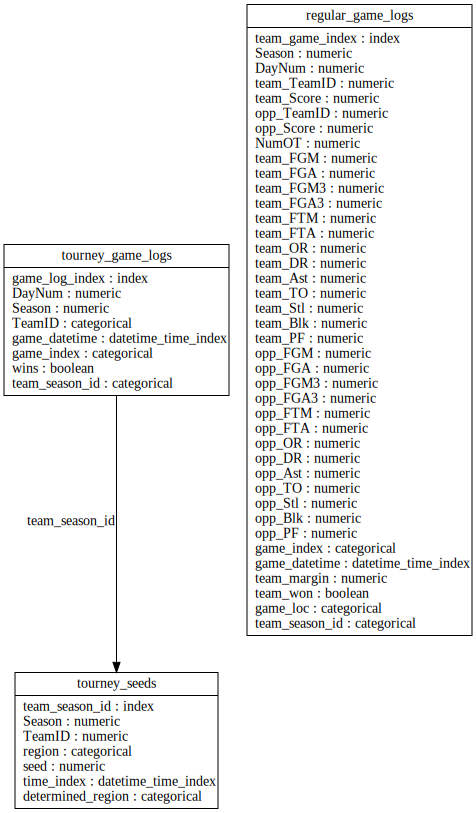

In [15]:
base_es = ft.EntitySet()
#compound key index?
base_es = base_es.entity_from_dataframe(entity_id="tourney_game_logs",
                             dataframe=tourney_game_logs,
                              index="game_log_index",
                              time_index="game_datetime"
                             )

base_es = base_es.entity_from_dataframe(entity_id="tourney_seeds",
                             dataframe=tourney_seeds_full,
                              index="team_season_id",
                              time_index="time_index"
                             )

base_es = base_es.entity_from_dataframe(entity_id="regular_game_logs",
                             dataframe=team_game_log,
                              index="team_game_index",
                              time_index="game_datetime"
                             )
#deepcopy is a relic from dynamic feature building I tried. keeping for now in case useful later
from copy import deepcopy
es=deepcopy(base_es)
#many to many
# es = es.add_relationship(
#     ft.Relationship(
#                     es['regular_game_logs']['team_season_id'],
#                     es['tourney_game_logs']["team_season_id"], 
#                    )
# )
es = es.add_relationship(
    ft.Relationship(
                    es['tourney_seeds']['team_season_id'],

                    es['tourney_game_logs']["team_season_id"], 
                   )
)
es.plot()

In [16]:

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="tourney_game_logs",
                                      verbose=True,
#                                       cutoff_time=datetime.datetime(2016,5,20),
#                                       cutoff_time_in_index=True,
                                      ignore_variables={
                                          "tourney_game_logs": ["DayNum","Season", "team1_season_id","team2_season_id"],
                                          "tourney_seeds": ["Seed","DayNum","Season", "TeamID", "team_game_index","time_index"]
                                      },
                                      agg_primitives=[],#Can't agg tourney_game_logs because pred comes before tourney start
                                      trans_primitives=["month", "weekday"]

                                     )
feature_matrix.head()

Built 9 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,TeamID,game_index,wins,team_season_id,MONTH(game_datetime),WEEKDAY(game_datetime),tourney_seeds.region,tourney_seeds.seed,tourney_seeds.determined_region
game_log_index,,,,,,,,,
1985_1104_11121104,1104,1985_1104_1112,True,1985_1104,3,4,X,7,West
1985_1104_11121112,1112,1985_1104_1112,False,1985_1112,3,4,X,10,West
1985_1104_13011104,1104,1985_1104_1301,False,1985_1104,3,4,X,7,West
1985_1104_13011301,1301,1985_1104_1301,True,1985_1301,3,4,X,3,West
1985_1104_14331104,1104,1985_1104_1433,True,1985_1104,3,6,X,7,West


In [17]:
#Wasn't sure how to get rid of certain id columns but still use them for understanding generated features
to_encode=[col for col in feature_matrix if "id" not in col.lower() and "index" not in col.lower() and col!="wins"]
fm_encoded, features_encoded = ft.encode_features(feature_matrix, feature_defs, to_encode=to_encode)

# Merge Features Back
I duplicated merged results, games, with different team prefix so team_i should be irrelevant and we can create a model with feature interactions between the teams. This does lose out on some feature tools primitives and DFS (e.g. seed1 seed2 interactions). It would be nice to run DFS on the different seeds together but I think I ran into issues because it results in a "diamond graph".  
    

In [18]:
#could also do a join based on win split but this is more generic for other sports because ties
merged_features=pd.DataFrame()
for game_index, game in fm_encoded.groupby("game_index"):
    assert(len(game)==2)
    merged=pd.DataFrame([game.iloc[0]]).merge(pd.DataFrame([game.iloc[1]]), on="game_index", suffixes=["_team1","_team2"])
    merged2=pd.DataFrame([game.iloc[0]]).merge(pd.DataFrame([game.iloc[1]]), on="game_index", suffixes=["_team2","_team1"])
    merged_features=merged_features.append(merged, sort=False).append(merged2, sort=False)
    

# Model

In [19]:
#I based this off of https://github.com/Featuretools/predict-next-purchase
y=merged_features['wins_team1']
keep_cols=[col for col in merged_features if "id" not in col.lower() and "index" not in col.lower() and "wins" not in col]
X=merged_features[keep_cols].fillna(0)
print(len(y),len(X))
X

4368 4368


,MONTH(game_datetime) = 3_team1,MONTH(game_datetime) = 4_team1,MONTH(game_datetime) is unknown_team1,WEEKDAY(game_datetime) = 4_team1,WEEKDAY(game_datetime) = 3_team1,WEEKDAY(game_datetime) = 5_team1,WEEKDAY(game_datetime) = 6_team1,WEEKDAY(game_datetime) = 0_team1,WEEKDAY(game_datetime) = 1_team1,WEEKDAY(game_datetime) = 2_team1,WEEKDAY(game_datetime) is unknown_team1,tourney_seeds.region = Y_team1,tourney_seeds.region = W_team1,tourney_seeds.region = Z_team1,tourney_seeds.region = X_team1,tourney_seeds.region is unknown_team1,tourney_seeds.seed_team1,tourney_seeds.determined_region = East_team1,tourney_seeds.determined_region = West_team1,tourney_seeds.determined_region = South_team1,tourney_seeds.determined_region = Southeast_team1,tourney_seeds.determined_region = Atlanta_team1,tourney_seeds.determined_region = Syracuse_team1,tourney_seeds.determined_region = StLouis_team1,tourney_seeds.determined_region = Minneapolis_team1,tourney_seeds.determined_region = Southwest_team1,tourney_seeds.determined_region is unknown_team1,MONTH(game_datetime) = 3_team2,MONTH(game_datetime) = 4_team2,MONTH(game_datetime) is unknown_team2,WEEKDAY(game_datetime) = 4_team2,WEEKDAY(game_datetime) = 3_team2,WEEKDAY(game_datetime) = 5_team2,WEEKDAY(game_datetime) = 6_team2,WEEKDAY(game_datetime) = 0_team2,WEEKDAY(game_datetime) = 1_team2,WEEKDAY(game_datetime) = 2_team2,WEEKDAY(game_datetime) is unknown_team2,tourney_seeds.region = Y_team2,tourney_seeds.region = W_team2,tourney_seeds.region = Z_team2,tourney_seeds.region = X_team2,tourney_seeds.region is unknown_team2,tourney_seeds.seed_team2,tourney_seeds.determined_region = East_team2,tourney_seeds.determined_region = West_team2,tourney_seeds.determined_region = South_team2,tourney_seeds.determined_region = Southeast_team2,tourney_seeds.determined_region = Atlanta_team2,tourney_seeds.determined_region = Syracuse_team2,tourney_seeds.determined_region = StLouis_team2,tourney_seeds.determined_region = Minneapolis_team2,tourney_seeds.determined_region = Southwest_team2,tourney_seeds.determined_region is unknown_team2
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,7,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,10,0,1,0,0,0,0,0,0,0,0
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,10,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,7,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5,1,0,0,0,0,0,0,0,0,0
0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s finished


'AUC 0.73 +/- 0.01'

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=23)
clf.fit(X_train, y_train)
import utils
from importlib import reload
reload(utils)
utils.feature_importances(clf, X.columns, n=300)

y_hat_train=clf.predict_proba(X_train)[:,1]
y_hat_test=clf.predict_proba(X_test)[:,1]
print()
print("Log Loss")
print("TRAIN:",log_loss(y_train,y_hat_train))
print("TEST:",log_loss(y_test,y_hat_test))
print()
print("Accuracy")
print("TRAIN:",accuracy_score(y_train, clf.predict(X_train)))
print("TEST:",accuracy_score(y_test, clf.predict(X_test)))

1: Feature: tourney_seeds.seed_team2, 0.385
2: Feature: tourney_seeds.seed_team1, 0.373
3: Feature: tourney_seeds.determined_region = South_team2, 0.013
4: Feature: tourney_seeds.determined_region = Southeast_team2, 0.012
5: Feature: tourney_seeds.determined_region = South_team1, 0.012
6: Feature: tourney_seeds.determined_region = Southeast_team1, 0.011
7: Feature: tourney_seeds.determined_region = West_team1, 0.010
8: Feature: tourney_seeds.determined_region = West_team2, 0.009
9: Feature: tourney_seeds.determined_region is unknown_team2, 0.008
10: Feature: tourney_seeds.region = X_team1, 0.008
11: Feature: tourney_seeds.region = Y_team2, 0.008
12: Feature: tourney_seeds.determined_region is unknown_team1, 0.008
13: Feature: tourney_seeds.region = X_team2, 0.008
14: Feature: WEEKDAY(game_datetime) = 4_team2, 0.008
15: Feature: tourney_seeds.region = Y_team1, 0.008
16: Feature: tourney_seeds.region = Z_team2, 0.008
17: Feature: tourney_seeds.region = Z_team1, 0.007
18: Feature: WEEKDAY

In [24]:
#over-fitting but log loss should be better. Let's clip
np=pd.np
y_hat_train=np.clip(clf.predict_proba(X_train)[:,1],.3,.7)
y_hat_test=np.clip(clf.predict_proba(X_test)[:,1],.3,.7)
print()
print("Log Loss")
print("TRAIN:",log_loss(y_train,y_hat_train))
print("TEST:",log_loss(y_test,y_hat_test))
print()
print("Accuracy")
print("TRAIN:",accuracy_score(y_train, clf.predict(X_train)))
print("TEST:",accuracy_score(y_test, clf.predict(X_test)))


Log Loss
TRAIN: 0.4737622027906773
TEST: 0.632605062592361

Accuracy
TRAIN: 0.8498527968596663
TEST: 0.6460717009916095


# Article Interest Piece
I think it would be interesting to have a small section focused on contest strategy using the log loss metric.  
https://www.kaggle.com/c/mens-machine-learning-competition-2019/discussion/80692 suggests a 0.025, .975 clip but using a clip of .3,.7 would perform quantifiably better in the case of a big upset. Say a 2 beats a 15. I'm thinking of highlighting lessons I've learned from daily fantasy sports to expose yourself to asymmetric payoffs in beneficial ways (the "best" model is tough, we can potentially create a .05 log loss gain across other competitors by anticipating an upset.) Also known as black swans.  
This can be good strategy once I feel the model is in a spot where marginal improvements are less than the gain of this strategy. Regardless I think it would be interesting to highlight in an article and provide historical anecdotes.

# Few Score Charts

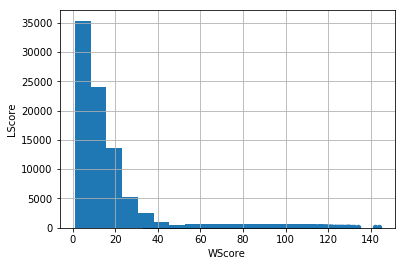

In [25]:
import matplotlib.pyplot as plt
regular_season_results_df[['WScore','LScore']].plot(kind="scatter", x="WScore",y="LScore")
regular_season_results_df['winner_margin']=regular_season_results_df['WScore']-regular_season_results_df['LScore']
regular_season_results_df['winner_margin'].hist()

count    73730.000000
mean         5.748298
             ...     
75%         14.000000
max         75.000000
Name: margin, Length: 8, dtype: float64


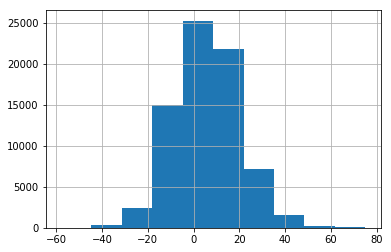

In [26]:
home_games=team_game_log[team_game_log['game_loc']=='H'].copy()
home_games['margin']=home_games['team_Score']-home_games['opp_Score']
print(home_games['margin'].describe())
home_games['margin'].hist()

# Elo
Elo generally offers good accuracy with few features, game location, team1_score and team2_score. I based this adaptation from [538](https://www.ergosum.co/nate-silvers-nba-elo-algorithm/) and used my code [here](https://nbviewer.jupyter.org/github/sportsdatadirect/python_tutorials/blob/master/Power%20Rankings.ipynb).  
  
- Below has Regular season training only 
  - (adding tourney results would be good)
- I adjusted home advantage to the average home advantage for all regular season games since 2003: 5.7



In [27]:
#sort and last so we get game_loc=H when game is H. N is fine too
matchups=team_game_log.sort_values(by=["game_index","game_loc"]).groupby("game_index").last()
matchups

,Season,DayNum,team_TeamID,team_Score,opp_TeamID,opp_Score,NumOT,team_FGM,team_FGA,team_FGM3,team_FGA3,team_FTM,team_FTA,team_OR,team_DR,team_Ast,team_TO,team_Stl,team_Blk,team_PF,opp_FGM,opp_FGA,opp_FGM3,opp_FGA3,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,game_datetime,team_margin,team_won,game_loc,team_season_id,team_game_index
game_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003100_11101298,2003,100,1298,61,1110,64,0,24,48,7,15,6,12,6,26,17,18,5,1,23,22,53,10,21,10,20,11,23,15,10,6,0,18,2003-02-12,-3,False,H,2003_1298,2003100_111012981298
2003100_11231245,2003,100,1123,83,1245,75,0,27,63,6,20,23,28,13,26,15,8,6,0,18,31,68,5,18,8,17,17,27,18,15,3,3,26,2003-02-12,8,True,H,2003_1123,2003100_112312451123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201899_14551272,2018,99,1272,65,1455,85,0,20,45,2,13,23,31,5,23,11,18,5,4,24,27,64,11,31,20,26,14,25,18,8,9,3,28,2018-02-06,-20,False,H,2018_1272,201899_145512721272
201899_14621139,2018,99,1139,93,1462,98,1,33,62,14,31,13,16,3,21,18,9,4,0,26,32,54,10,21,24,28,4,26,12,13,2,1,20,2018-02-06,-5,False,H,2018_1139,201899_146211391139


In [28]:
teams=pd.read_csv(DATA_ROOT+"/DataFiles/Teams.csv").set_index("TeamID", drop=False)

In [29]:
#Elo implementation
from collections import defaultdict
np=pd.np
def silverK(MOV, elo_diff):
    K_0=20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return K_0*multiplier,K_0*multiplier

def silverS(home_score, away_score):
    S_home,S_away=0,0
    if home_score>away_score:
        S_home=1
    elif away_score>home_score:
        S_away=1
    else:
        S_home,S_away=.5,.5
    return S_home,S_away

def silver_elo_update(team_score, opp_score, team_rating, opp_rating, game_loc):
    HOME_AD=160.
    if game_loc=='A':
        opp_rating+=HOME_AD
    elif game_loc=='H':
        team_rating+=HOME_AD
    E_team = elo_prediction(team_rating,opp_rating)
    E_opp=1-E_team
    elo_diff=team_rating-opp_rating
    MOV=team_score-opp_score
    
    S_team,S_opp = silverS(team_score,opp_score)
    if team_score>=opp_score:
        elo_winner=team_rating
        elo_loser=opp_rating
    else:
        elo_loser=team_rating
        elo_winner=opp_rating

    K_team,K_opp =  silverK(MOV,elo_winner-elo_loser)
        
    return K_team*(S_team-E_team),K_opp*(S_opp-E_opp)

def elo_prediction(home_rating,away_rating):
    E_home = 1./(1 + 10 ** ((away_rating - home_rating) / (400.)))
    return E_home

def score_prediction(home_rating,away_rating):
    return (home_rating-away_rating)/28.
class HeadToHeadModel(object):
    def __init__(self, events, update_function, prediction_function=None):
        self.update_function=update_function
        self.events=events
        self.ratings=defaultdict(lambda: 1300)
        self.prediction_function = prediction_function
        self.predictions = []
        self.curr_season=defaultdict(lambda: self.events[0][1]['Season'])

    def compute_elo_ratings(self):
        for idx, event in self.events:
            new_year=event['Season']
            label_i=event['team_TeamID']
            label_j=event['opp_TeamID']
            
            if self.curr_season[label_i]!=new_year:
                self.curr_season[label_i]=new_year
                self.ratings[label_i]=self.ratings[label_i]*.25+1505.*.75
            elif self.curr_season[label_j]!=new_year:
                self.curr_season[label_j]=new_year
                self.ratings[label_j]=self.ratings[label_j]*.75+1505.*.25
            #todo change below to just use event
            update=self.update_function(event['team_Score'],event['opp_Score'], self.ratings[label_i], self.ratings[label_j], event['game_loc'])
            self.ratings[label_i]+=update[0]
            self.ratings[label_j]+=update[1]
            

    def power_rankings(self):
        from operator import itemgetter
        #sort dictionary by value to get ascending list of teams
        power_rankings = sorted(self.ratings.items(), key=itemgetter(1), reverse=True)
        power = []
        #Make the 0-th team 1st
        for i, x in enumerate(power_rankings):
            power.append((i + 1, teams.loc[x[0]]['TeamName'],x[1]))
        return power
m=HeadToHeadModel(list(matchups[matchups['Season']<=2018].iterrows()), silver_elo_update, elo_prediction)
m.compute_elo_ratings()
m.power_rankings()

[(1, 'Villanova', 1824.175150150114),
 (2, 'Cincinnati', 1793.190736376901),
 (3, 'Virginia', 1769.1841932489313),
 (4, 'Gonzaga', 1759.991852375316),
 (5, 'Purdue', 1738.8172602419684),
 (6, 'Kansas', 1729.8129525685342),
 (7, 'Nevada', 1713.8124130193426),
 (8, "St Mary's CA", 1713.76851138374),
 (9, 'ETSU', 1713.3130782286435),
 (10, 'Vermont', 1708.5959770412887),
 (11, 'New Mexico St', 1708.5246101857483),
 (12, 'Duke', 1707.7036352478449),
 (13, 'Kentucky', 1702.8974452502202),
 (14, 'Wichita St', 1700.6967102723736),
 (15, 'ULL', 1699.5603747840462),
 (16, 'Michigan St', 1697.2404872085415),
 (17, 'Arizona', 1695.702263125348),
 (18, 'Xavier', 1684.9085150769868),
 (19, 'Houston', 1682.0745172241852),
 (20, 'Loyola-Chicago', 1672.5027404331674),
 (21, 'Auburn', 1670.8031752361503),
 (22, 'Tennessee', 1669.5336716670424),
 (23, 'Rhode Island', 1668.8542213349956),
 (24, 'North Carolina', 1668.4573081590295),
 (25, 'Buffalo', 1667.9573439119267),
 (26, 'Bucknell', 1665.89990315843

I think Elo is a good start but needs some adjustments to handle all the upsets. E.g. 2018 (marshall, virginia,Loyola, etc) Cincinatti looks a little high.  
These may be handled by a conference factor, tourney data, higher K, or more mean reversion in between seasons

## Score Elo

In [30]:
#We need to generate a prediction for every possible pairing
from itertools import combinations
tourney_seeds=pd.read_csv(DATA_ROOT+"/DataFiles/NCAATourneySeeds.csv")
possible_games_df=pd.DataFrame()
for season, seeds in tourney_seeds.groupby("Season"):
    possible_games=list(combinations(tourney_seeds[tourney_seeds['Season']==season]['TeamID'],2))
    df=pd.DataFrame(possible_games,columns=["Team1_ID","Team2_ID"])
    df['Season']=season
    possible_games_df=possible_games_df.append(df)
possible_games_df=possible_games_df[possible_games_df['Season']>=2014]
possible_games_df['game_index']=possible_games_df.apply(lambda row: "%s_%s_%s"%(row['Season'],min([row["Team1_ID"],row["Team2_ID"]]),max([row["Team1_ID"],row["Team2_ID"]])), axis=1)

possible_games_df['TeamID']=possible_games_df.apply(lambda row: min([row["Team1_ID"],row["Team2_ID"]]),axis=1)
possible_games_df['ID']=possible_games_df.apply(lambda row: "%s_%s_%s"%(row['Season'],min([row["Team1_ID"],row["Team2_ID"]]),max([row["Team1_ID"],row["Team2_ID"]])), axis=1)
possible_games_df

,Team1_ID,Team2_ID,Season,game_index,TeamID,ID
0,1438,1437,2014,2014_1437_1438,1437,2014_1437_1438
1,1438,1235,2014,2014_1235_1438,1235,2014_1235_1438
...,...,...,...,...,...,...
2276,1252,1411,2018,2018_1252_1411,1252,2018_1252_1411
2277,1300,1411,2018,2018_1300_1411,1300,2018_1300_1411


In [31]:
#Make a different model for each season using all past data before tourney
models={}
for season in range(2014,2018+1):
    print(season)
    #could be optimized but data is small
    m=HeadToHeadModel(list(matchups[matchups['Season']<=season].iterrows()), silver_elo_update, elo_prediction)
    m.compute_elo_ratings()
    m.power_rankings()
    models[season]=m

2014
2015
2016
2017
2018


In [32]:
#predict for every game
def get_elo_probability(row):
    m=models[row['Season']]
    team1,team2=sorted([row[0],row[1]])
    return elo_prediction(m.ratings[team1],m.ratings[team2])
possible_games_df['elo_win_probability']=possible_games_df.apply(get_elo_probability, axis=1)
possible_games_df['elo_win']=possible_games_df['elo_win_probability'].apply(lambda x: 1 if x>=.5 else 0)
possible_games_df['Pred']=possible_games_df['elo_win_probability']#np.clip(possible_games_df['elo_win_probability'],.3,.7)

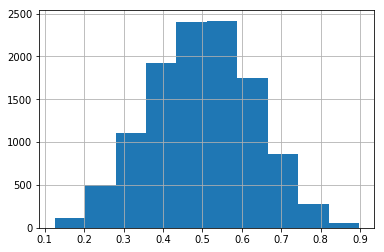

In [33]:
possible_games_df['Pred'].hist()

In [34]:
#merge predictions with actual results
tourney_results=pd.read_csv(DATA_ROOT+"/DataFiles/NCAATourneyCompactResults.csv")
for col in tourney_results.columns:
    if "ID" in col:
        tourney_results[col]=tourney_results[col].astype(str)
tourney_results['game_index']=tourney_results.apply(lambda row: "%s_%s_%s"%(row['Season'],min([row["WTeamID"],row["LTeamID"]]),max([row["WTeamID"],row["LTeamID"]])), axis=1)
tourney_results['lower_id_wins']=tourney_results.apply(lambda row: 1 if row['WTeamID']==row['game_index'].split("_")[1] else 0, axis=1)
predictions=tourney_results.merge(possible_games_df,on="game_index",how="left",suffixes=["","_y"])
predictions

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,game_index,lower_id_wins,Team1_ID,Team2_ID,Season_y,TeamID,ID,elo_win_probability,elo_win,Pred
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,2018,152,1437,95,1242,79,N,0,2018_1242_1437,0,1437.0,1242.0,2018.0,1242.0,2018_1242_1437,0.367445,0.0,0.367445
2183,2018,154,1437,79,1276,62,N,0,2018_1276_1437,0,1437.0,1276.0,2018.0,1276.0,2018_1276_1437,0.278881,0.0,0.278881


In [35]:
from sklearn.metrics import log_loss
log_loss(predictions[predictions['Season']>=2014]['lower_id_wins'],predictions[predictions['Season']>=2014]['elo_win_probability'])

0.6176410803025985

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions[predictions['Season']>=2014]['lower_id_wins'],predictions[predictions['Season']>=2014]['elo_win'])

0.6597014925373135

In [37]:
#slightly better results than the seeds, game_day, region model in terms of log loss and accuracy

## Kaggle Submission


In [38]:
possible_games_df[['ID','Pred']].to_csv("elo_model.csv",index=False)

# Next Steps
- log loss tuning
- Use feature tools on team_game_logs to replicate stats (here)[https://www.basketball-reference.com/about/glossary.html] and potentially find new ones using custom primitives. 
  - Need to add something for percentages
- Add winners of conference tourney (example Big 10 Championship) to the data and Elo model.
- Add massey ordinals and other advanced stats. Highlight featuretools easy data management through entity sets.
- Use play by play data to compute things like garbage time and competitiveness. It does not have play location but has enough to give good info
- Any thoughts on feature selection process? I didn't see much on FT website beyond RandomForest feature importance. In your thesis I saw something about Gaussian Coppula processes. For now I think there aren't enough features but once I add ones from play by play and team game logs it could become more important
- Some refactoring on index creation and getting standard data like game_logs